In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

#MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/modelsave/'

#IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagewoof2'

IMAGENETTEPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagenette2'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("torch version:", torch.__version__)
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch version: 1.7.0+cu101
check device: Tesla V100-SXM2-16GB
how many?: 1
so can i use it? True


In [4]:
"""from google.colab import output
!mkdir "./train"
!mkdir "./val"
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/train.zip" "train.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/val.zip" "val.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "train.zip" -d "./train/"
!unzip "val.zip" -d "./val/"
"""

'from google.colab import output\n!mkdir "./train"\n!mkdir "./val"\n# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기\n!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/train.zip" "train.zip"\n!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/val.zip" "val.zip"\n# data_2.zip을 현재 디렉터리에 압축해제\n!unzip "train.zip" -d "./train/"\n!unzip "val.zip" -d "./val/"\n'

In [5]:
# transformation for CIFAR 10
# yet to implement standard color augmentation

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224, padding=28),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),         
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [6]:
train_set = torchvision.datasets.ImageFolder(root='./train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root='./val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')

train_loader 296
test_loader 123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


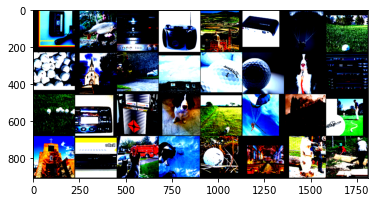

In [7]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [8]:
# define the basic building blocks for ResNet

# option A
class Padding(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super(Padding, self).__init__()
        self.padding = F.pad
        self.pad_dim = (out_c - in_c) / 2
        self.pad_dim = int(self.pad_dim)
        self.downsample = nn.MaxPool2d(1, stride=stride)

    def forward(self, x):
        x = self.padding(x, (0,0,0,0, self.pad_dim, self.pad_dim), "constant", 0)
        x = self.downsample(x)
        return x

# option Mine
class Concat(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super(Concat, self).__init__()
        
        self.dim_remainder = (out_c - in_c) % in_c
        self.concat_times = out_c // in_c
        self.downsample = nn.MaxPool2d(1, stride=stride)


    def forward(self, x):
        #print("cat 1", x.shape)
        #print(self.concat_times)
        cat_x = [x] * self.concat_times
        cat_x = torch.cat(cat_x, dim=1)
        #cat_x = torch.cat((cat_x, x[:self.dim_remainder]), dim=1)
        cat_x = self.downsample(cat_x)
        #print(cat_x.shape)

        return cat_x

class BuildingBlock(nn.Module):

    def __init__(self, in_c, out_c, stride=1, option='B'):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.shortcut = nn.Sequential()
        if in_c != out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, out_c, stride)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, out_c, stride)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [9]:
class Bottleneck(nn.Module):

    def __init__(self, in_c, process_c, stride=1, option='B'):
        super(Bottleneck, self).__init__()

        self.out_c = process_c * 4

        self.conv1 = nn.Conv2d(in_c, process_c, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(process_c)

        self.conv2 = nn.Conv2d(process_c, process_c, kernel_size=3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(process_c)

        self.conv3 = nn.Conv2d(process_c, self.out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(self.out_c)

        self.shortcut = nn.Sequential()
        if in_c != self.out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, self.out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, self.out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(self.out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, self.out_c)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        # slightly changed for CIFAR10
        # in order to have dimension 32x32 --> 16x16
        self.conv_gate = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_gate = nn.BatchNorm2d(64)
        self.maxpool_gate = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn_gate(self.conv_gate(x)))
        x = self.maxpool_gate(x)
        return x

In [10]:
class ResVGG(nn.Module):
    def __init__(self):
        super(ResVGG, self).__init__()

        self.conv1 = BuildingBlock(3, 64, 1, 'B')

        self.conv2 = BuildingBlock(64, 128, 1, 'B')

        self.conv3_1 = BuildingBlock(128, 256, 1, 'B')
        self.conv3_2 = BuildingBlock(256, 256, 1, 'B')

        self.conv4_1 = BuildingBlock(256, 512, 1, 'B')
        self.conv4_2 = BuildingBlock(512, 512, 1, 'B')

        self.conv5_1 = BuildingBlock(512, 512, 1, 'B')
        self.conv5_2 = BuildingBlock(512, 512, 1, 'B')

        self.fc = nn.Linear(25088, 10)

    def forward(self, x):

        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)

        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)

        x = self.conv3_1(x)
        x = F.max_pool2d(self.conv3_2(x), kernel_size=2, stride=2)

        x = self.conv4_1(x)
        x = F.max_pool2d(self.conv4_2(x), kernel_size=2, stride=2)

        x = self.conv5_1(x)
        x = F.max_pool2d(self.conv5_2(x), kernel_size=2, stride=2)

        x = x.view(-1, 25088)

        x = self.fc(x)

        return x

In [11]:
resnet = ResVGG()
resnet.to(device)

ResVGG(
  (conv1): BuildingBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): BuildingBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #print(m)
        init.kaiming_normal_(m.weight)
        #torch.nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        #print(m)
        init.kaiming_normal_(m.weight)
        init.zeros_(m.bias)

    # no initialization for BatchNorm2d

In [13]:
resnet.apply(weights_init)

ResVGG(
  (conv1): BuildingBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): BuildingBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=

In [14]:
def train_one_epoch(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = model(image)
        loss = loss_function(pred, label)
    
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : loss {running_loss/length:.4f}')


def eval_one_epoch(model, test_loader, epoch):
    model.eval()
    length = len(test_loader)
    running_acc = 0.0

    for i, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.numpy()

        pred = model(image)
        pred_label = pred.argmax(axis=1).detach().cpu().numpy()
        running_acc += (pred_label==label).mean()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')

    val_acc = running_acc/length

    print(f'epoch {epoch} : acc {val_acc:.4f}')

    return val_acc

In [15]:
# hyperparameters from paper
# assuming same for pretraining

learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 100

In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, 
                            momentum=momentum, weight_decay=weight_decay)

milestones = [60, 80]

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.1
)

# 391 iterations per epoch
# 32k iter = 82 epochs
# 42k iter = 108 epochs
# 64k iter = 164 epochs

In [17]:
val_acc_list = []

for epoch in range(epochs):
    train_one_epoch(resnet, train_loader, loss_function, optimizer, epoch)
    val_acc_list.append(eval_one_epoch(resnet, test_loader, epoch))
    scheduler.step()

after looking at 128 images, running_loss is 8.4205
after looking at 6528 images, running_loss is 116.0296
after looking at 12928 images, running_loss is 59.7460
after looking at 19328 images, running_loss is 40.7209
after looking at 25728 images, running_loss is 31.1636
after looking at 32128 images, running_loss is 25.4144
epoch 0 : loss 21.8992
after looking at 128 images, running_acc is 0.0000
after looking at 6528 images, running_acc is 0.0092
after looking at 12928 images, running_acc is 0.1117
epoch 0 : acc 0.1069
after looking at 128 images, running_loss is 2.2624
after looking at 6528 images, running_loss is 2.2973
after looking at 12928 images, running_loss is 2.2911
after looking at 19328 images, running_loss is 2.2836
after looking at 25728 images, running_loss is 2.2827
after looking at 32128 images, running_loss is 2.2725
epoch 1 : loss 2.2670
after looking at 128 images, running_acc is 0.0938
after looking at 6528 images, running_acc is 0.2126
after looking at 12928 imag

In [18]:
val_acc_list

[0.10685249709639953,
 0.16173054587688734,
 0.22770276809910955,
 0.23265098722415795,
 0.2585777197057685,
 0.28397212543554007,
 0.2912190282617112,
 0.28930749128919864,
 0.3018897599690282,
 0.3227230933023616,
 0.318645954316686,
 0.365781068524971,
 0.35077913279132794,
 0.3735481997677119,
 0.3884170538133953,
 0.4210341656987998,
 0.43374951606658924,
 0.4743999225706543,
 0.4688104916763453,
 0.5099690282617112,
 0.5210269066976384,
 0.5337180603948897,
 0.5586164343786295,
 0.5607941347270615,
 0.568283004258614,
 0.6001621176926055,
 0.6039730933023616,
 0.6163012969415408,
 0.6279882888114595,
 0.6433652729384437,
 0.651749419279907,
 0.6602545489740611,
 0.6785472319008904,
 0.6626742160278746,
 0.6626621176926055,
 0.6650938830816879,
 0.6666061749903213,
 0.6957026713124274,
 0.6833744676732482,
 0.6860481997677119,
 0.7034456058846302,
 0.711708768873403,
 0.681729094076655,
 0.7180603948896631,
 0.718943573364305,
 0.7014251838946961,
 0.667622435152923,
 0.7061072396

In [19]:
torch.randn([128, 512, 2, 2])

tensor([[[[-1.1599e+00, -1.0503e+00],
          [ 9.6526e-01, -1.0467e+00]],

         [[-1.1939e-01, -2.1313e-01],
          [-3.9868e-01,  1.0683e+00]],

         [[ 1.3720e-01, -8.6428e-01],
          [-3.7922e-01, -3.2487e-01]],

         ...,

         [[-9.8208e-01, -1.7760e+00],
          [ 4.8460e-01,  3.9807e-01]],

         [[ 3.8465e-01, -2.8342e-01],
          [-2.4390e-01,  2.1691e+00]],

         [[ 7.0524e-01,  3.7843e-01],
          [ 3.0477e-01, -2.1748e+00]]],


        [[[-1.0488e+00, -5.1574e-01],
          [-1.6765e+00,  1.3578e+00]],

         [[-1.8430e+00, -6.9826e-01],
          [ 8.3649e-03, -4.8115e-01]],

         [[ 1.4349e+00,  8.2842e-01],
          [ 1.1887e+00,  5.8644e-01]],

         ...,

         [[ 2.0750e+00,  1.5230e+00],
          [ 1.7222e+00, -1.2900e+00]],

         [[-2.1893e-02,  5.2591e-01],
          [ 1.0173e-02, -6.7370e-01]],

         [[-1.1678e+00,  7.3546e-01],
          [ 5.2903e-02,  2.5465e-01]]],


        [[[-1.5761e+00, -1.517

In [20]:
torch.cat(cat, dim=0).shape

NameError: ignored

In [ ]:
torch.cat((t4d, t4d), dim=0)

In [ ]:
F.pad(t4d, (1,1,1,1,4,4))

In [ ]:
F.avg_pool2d(torch.randn([128, 512, 2, 2]), 2)

In [ ]:
6